In [1]:
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D
from tensorflow.keras import regularizers
from pathlib import Path
from tensorflow import keras
from livelossplot.inputs.keras import PlotLossesCallback
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pickle

In [2]:
batch_size = 2
#train= tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.2, 
#                                                       zoom_range=0.2, 
#                                                       horizontal_flip=True,
#                                                       fill_mode="nearest",
#                                                       rotation_range=25,
#                                                       preprocessing_function=preprocess_input)

train= tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.2, rotation_range=90, 
                                                     width_shift_range=0.5, 
                                                     height_shift_range=0.5,
                                                     zoom_range=0.2,
                                                    horizontal_flip=True, 
                                                     vertical_flip=True,
                                                     preprocessing_function=preprocess_input)


test= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

In [3]:
traingen = train.flow_from_directory(directory="train",
                                        target_size=(224,224), 
                                        class_mode='categorical',
                                        shuffle= True,
                                        )

Found 6005 images belonging to 102 classes.


In [4]:
validgen = test.flow_from_directory(directory="val", 
                                   target_size=(224,224), 
                                   class_mode='categorical',
                                    shuffle= True,
                                    )

Found 1019 images belonging to 102 classes.


In [5]:
dit ="image_00070.jpg"
pic = load_img(dit)
pic_array = img_to_array(pic)
pic_array = pic_array.reshape((1, )+ pic_array.shape)
pic_array.shape

(1, 500, 667, 3)

count = 0
for batch in train.flow(pic_array, batch_size = 1, save_to_dir = "image_traingen", save_prefix= 'flower', save_format='jpeg'):
    count +=1
    if count >35:
        break

In [6]:
kernel_regularizer1 = tf.keras.regularizers.l1(0.01)
activity_regularizer2 = tf.keras.regularizers.l2(0.01)

In [7]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    print("optimizer: ", optimizer)
    vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))
    
    if fine_tune > 0:
        for layer in vgg_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in vgg_model.layers:
            layer.trainable = False
            
            
    top_model = vgg_model.output
    #top_model = Dropout(0.5)(top_model)
    top_model = AveragePooling2D(pool_size=(4, 4))(top_model)
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.001))(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001))(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(n_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.001))(top_model)
    
    #-------------------------------------------------#
    model = Model(inputs=vgg_model.input, outputs=output_layer)
    #model.layers[22].trainable = False
    
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    

In [8]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.0001, decay=0.0001/100)
n_classes=102

n_steps = len(traingen)//batch_size
n_val_steps = len(validgen)//batch_size
n_epochs = 300

# First we'll train the model without Fine-tuning
vgg16_model = create_model(input_shape, n_classes, optim_1, fine_tune=4)

optimizer:  <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000002E1C39FC460>


In [9]:

vgg16_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [10]:
for i,layer in enumerate(vgg16_model.layers):
    print(i,layer.name," : " ,layer.trainable)

0 input_1  :  False
1 block1_conv1  :  False
2 block1_conv2  :  False
3 block1_pool  :  False
4 block2_conv1  :  False
5 block2_conv2  :  False
6 block2_pool  :  False
7 block3_conv1  :  False
8 block3_conv2  :  False
9 block3_conv3  :  False
10 block3_pool  :  False
11 block4_conv1  :  False
12 block4_conv2  :  False
13 block4_conv3  :  False
14 block4_pool  :  False
15 block5_conv1  :  True
16 block5_conv2  :  True
17 block5_conv3  :  True
18 block5_pool  :  True
19 average_pooling2d  :  True
20 flatten  :  True
21 dense  :  True
22 dropout  :  True
23 dense_1  :  True
24 dropout_1  :  True
25 dense_2  :  True


In [11]:


plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='VGG16_re_fun3.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

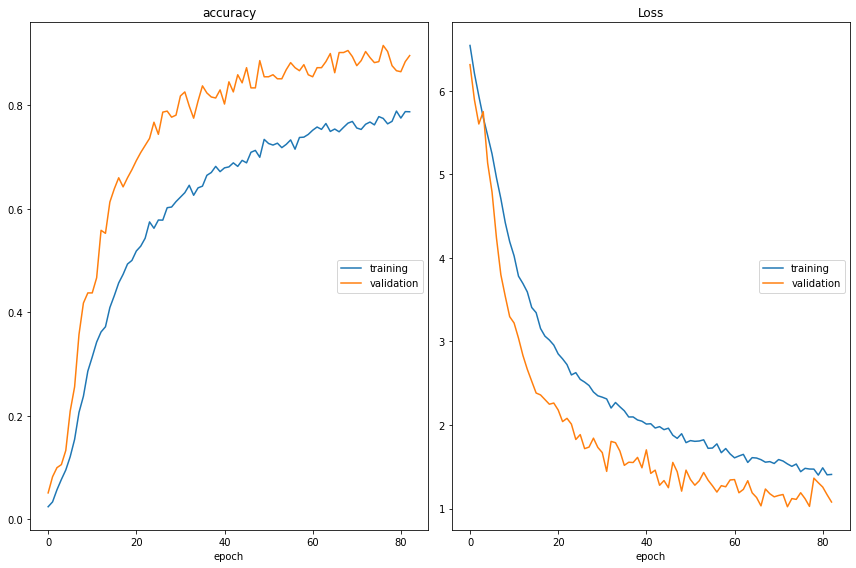

accuracy
	training         	 (min:    0.024, max:    0.789, cur:    0.788)
	validation       	 (min:    0.051, max:    0.916, cur:    0.896)
Loss
	training         	 (min:    1.400, max:    6.543, cur:    1.408)
	validation       	 (min:    1.021, max:    6.313, cur:    1.078)
94/94 [==============================] - 67s 709ms/step - loss: 1.4079 - accuracy: 0.7878 - val_loss: 1.0777 - val_accuracy: 0.8965


In [12]:
#vgg16_model.load_weights('4096-512.hdf5')
vgg_history = vgg16_model.fit(traingen,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            )

In [13]:
acc = vgg_history.history['accuracy']
val_acc = vgg_history.history['val_accuracy']

loss = vgg_history.history['loss']
val_loss = vgg_history.history['val_loss']

In [14]:
np.mean(val_acc[-40:])

0.875732421875

In [15]:
np.mean(acc[-30:])

0.7573203603426616

In [16]:
testgen = test.flow_from_directory(directory="test", 
                                   target_size=(224,224), 
                                   class_mode='categorical',
                                    )

Found 1165 images belonging to 102 classes.


In [17]:
#vgg16_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights
#vgg16_model.load_weights('4096-512.hdf5')
#vgg16_model.load_weights('VGG16_re_fun.hdf5')
#vgg16_model.load_weights('VGG16_re_fun2.hdf5') #only one dense

In [18]:
results = vgg16_model.evaluate(testgen)

37/37 [==============================] - 12s 333ms/step - loss: 1.1110 - accuracy: 0.9039


# predict

In [19]:
dataset_test ="test"
test_dir = Path(dataset_test)
test_data_image = list(test_dir.glob('*/*.jpg'))

In [20]:
a_file = open("data_array.pkl", "rb")
class_names = pickle.load(a_file)

FileNotFoundError: [Errno 2] No such file or directory: 'data_array.pkl'

In [ ]:
class_names[7]

In [ ]:
a_file1 = open("data.pkl", "rb")
flower_dict = pickle.load(a_file1)

In [ ]:

for img_path in test_data_image:
    img = keras.preprocessing.image.load_img( img_path, target_size=(224,224) )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    prediction = vgg16_model.predict(img_array)
    #print("------prediction-------")
    #print(prediction)
    #print("------prediction[0]-------")
    #print(prediction[0])
    score = tf.nn.softmax(prediction[0])
    #print("------------score---------")
    index = class_names[np.argmax(score)]
    int_index = int(index)
    print(img_path, ' : ', class_names[np.argmax(score)] ,' : ',flower_dict[int_index])
    #print(class_names[np.argmax(score)], " with ", 100 * np.max(score))

# Summary 

# Dataset 1

# no fine tunning
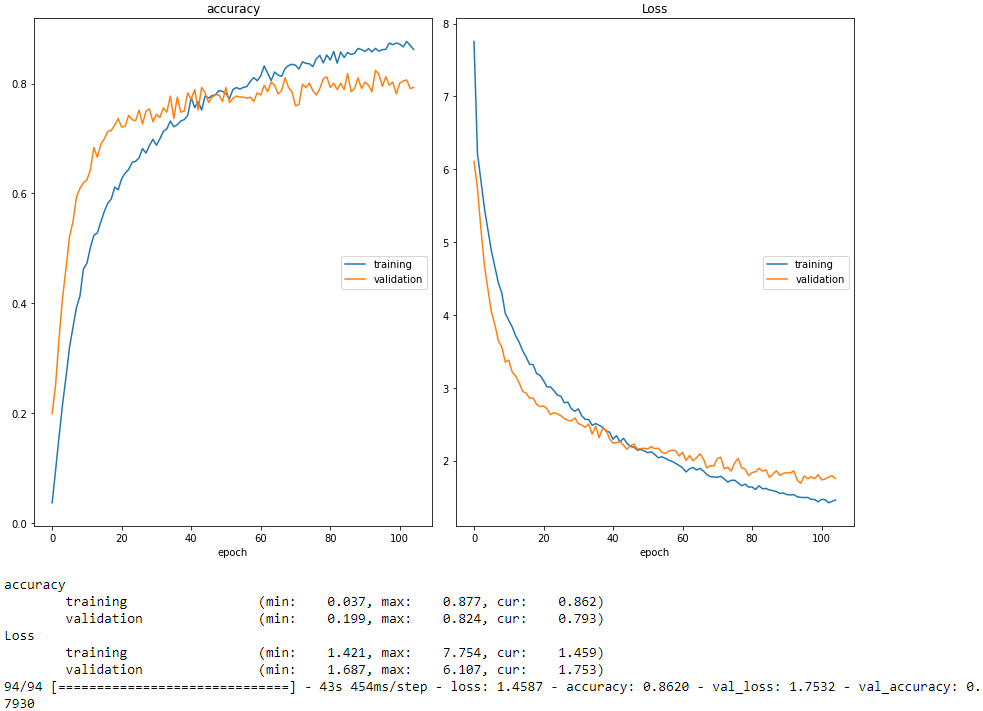
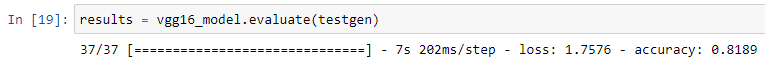

# 4 fine tunning
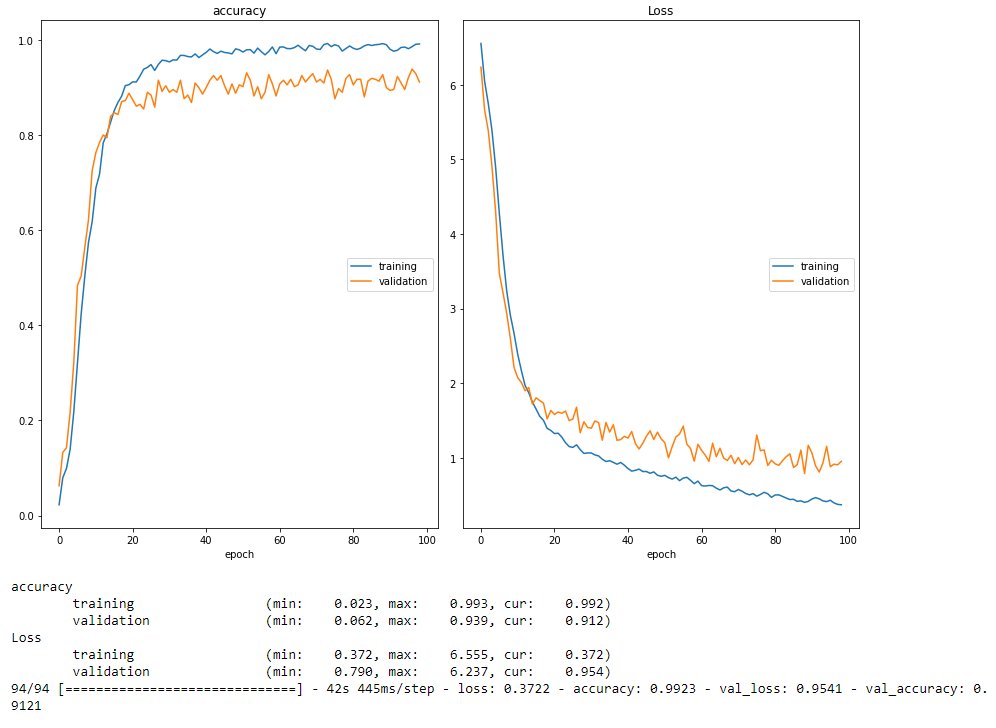
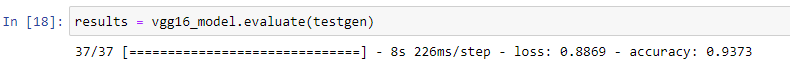

# Data Set 2

# no fine tunning
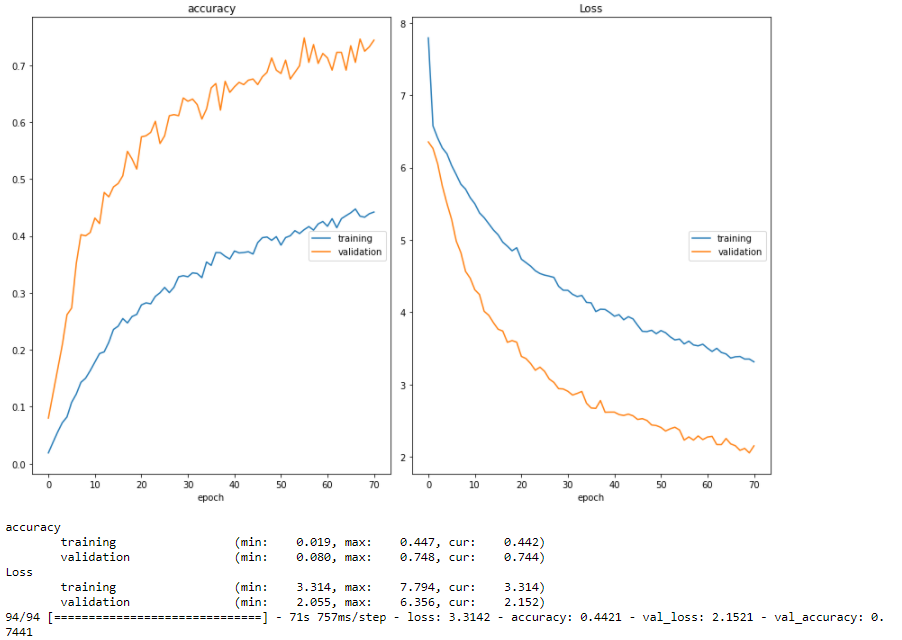

# fine tunning
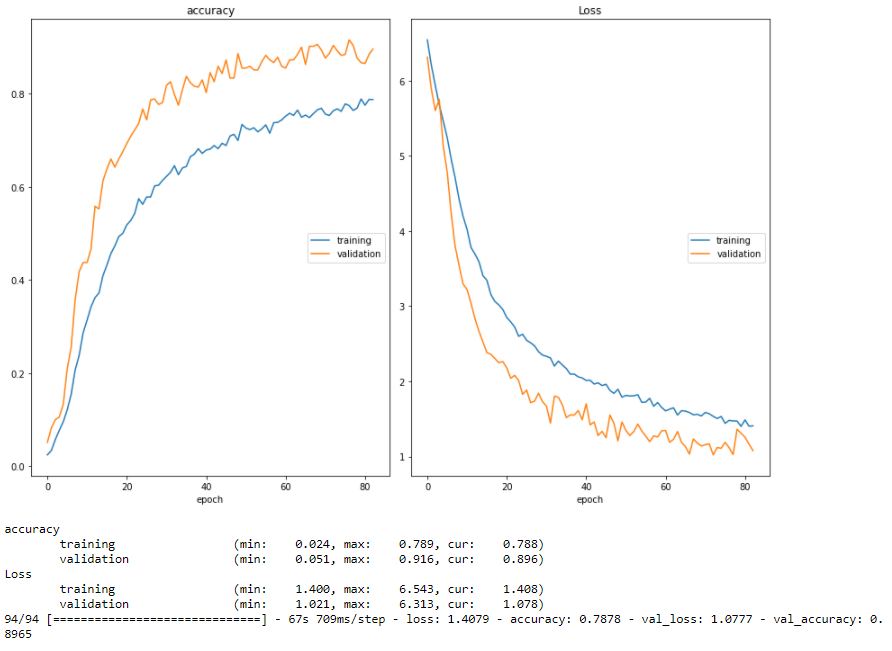